<a href="https://colab.research.google.com/github/marongkang/MLeveryday/blob/main/MLEveryday11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Logistic Regression

逻辑回归
> 适用于分类问题  
> 输入为不同类别的概率


**概述**  
$\hat{y}=\frac{1}{1+e^{-XW}}$  
where:  
*  $\hat{y}=预测值|\in\mathbb{R}^{NX1}$
*  $X=输入|\in\mathbb{R}^{NXD}$
*  $W=权重|\in\mathbb{R}^{DX1}$

逻辑回归的主要思想是用线性回归的输出值(z=XW)经过一个sigmoid函数($\frac{1}{1+e^{-Z}}$)来映射到(0,1)之间。

当有多于两个分类类别，我们需要使用多项式逻辑回归（softmax分类器）。softmax分类器将会用线性方程（z=XW）并且归一化它，来产生对应的类别y的概率。

$\hat{y}=\frac{e^{XW_y}}{\sum e^{XW}}$
where:
* $\hat{y}=预测值|\in\mathbb{R}^{NX1}(N是样本个数)$
* $X=输入|\in\mathbb{R}^{NXD}(D是特征的个数) $
* $W=权重|\in\mathbb{R}^{DXC}(C是类别的个数)$


* **目标**:通过输入值X来预测y的类别概率.softmax分类器将根据归一化线性输出来计算类别概率.
* **优点**:
>可以预测输入对应的类别概率;
* **缺点**
>因为使用的损失函数是要最小化交叉熵损失,所以对离群点很敏感.
* **其他**:softmax分类器在神经网络中广泛的用于最后一层,因为可以算出类别概率。

#训练
步骤：  
1. 随机初始化权重模型W.  
2. 将输入值X传入模型并且得到logits(z=XW).在logits上使用softmax操作得到独热编码后的类别概率$\hat{y}$.比如,如果有三个类别,预测出的类别概率可能为[0.3,0.3,0.4].
3. 使用损失函数将预测值$\hat{y}$和真实值做比较,并计算出损失值J.  
 一个常用的逻辑回归损失函数是交叉熵函数:  
 * $J(θ)=-∑_iy_iln(\hat{y_i})=-∑_iy_iln(\frac{e^{X_iW_y}}{∑e^{X_iW}}) $
 * $y=[0,0,1]$
 * $\hat{y}=[0.3,0.3,0.4]$
 * $J(θ)=-∑_iy_iln(\hat{y_i})=-∑_iy_iln(\frac{e^{X_iW_y}}{∑e^{X_iW}})=-∑_i[0*ln(0.3)+0*ln(0.3)+1*ln(0.4)]=-ln(0.4) $
 *  简化交叉熵函数:$J(θ)=-ln(\hat{y_i})(负的极大似然)$
 *  $J(θ)=-ln(\hat{y_i})=-ln(\frac{e^{X_iW_y}}{∑_ie^{X_iW}})$
4. 根据模型权重计算损失梯度$J(θ)$.假设类别分类是互斥的(一种输入只对应一种输出类别).
 * $\frac{∂J}{∂W_j}=\frac{∂J}{\partial{y}}\frac{∂y}{\partial{W_j}}=-\frac{1}{y}\frac{∂y}{∂W_j}=-\frac{1}{\frac{e^{W_yX}}{\sum{e^{XW}}}}\frac{e^{XW_eW_yX_0}-e^{W_yX_eW_jX_0}}{(∑e^{XW})^2}=\frac{X_eW_jX}{∑e^{XW}}=XP$
 * $\frac{∂J}{∂W_y}=\frac{∂J}{\partial{y}}\frac{∂y}{\partial{W_y}}=-\frac{1}{y}\frac{∂y}{∂W_y}=-\frac{1}{\frac{e^{W_yX}}{\sum{e^{XW}}}}\frac{e^{XW_eW_yX_0}-e^{W_yX_eW_jX_X}}{(∑e^{XW})^2}=\frac{1}{P}(XP-XP^2)=X(P-1)$
 5. 使用梯度下降法来对权重做反向传播以更新模型权重.更新后的模型权重将会使不正确的类别(j)概率大大降低,从而升高正确类别的(y)概率.
 * $W_i=W_i-α\frac{J}{W_i}$
6. 重复2-4步,直到模型表现最好.


In [ ]:
from argparse import Namespace
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib.request

In [ ]:
#参数
args=Namespace(
    seed=123,
    data_file="titanic.csv",
    train_size=0.75,
    test_size=0.25,
    num_epochs=100,
)

np.random.seed(args.seed)

In [ ]:
url="https://raw.githubusercontent.com/marongkang/datasets/main/titanic.csv"
response=urllib.request.urlopen(url)
html=response.read()
with open(args.data_file,'wb') as f:
  f.write(html)

In [ ]:
df=pd.read_csv(args.data_file,header=0)
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


# Scikit-learn实现
使用SGDClassifier类来做随机梯度下降

In [ ]:
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
def preprocess(df):
  df=df.dropna();
  features_to_drop=["Name","Cabin","Ticket","PassengerId"]
  df=df.drop(features_to_drop,axis=1)
  categorical_features=["Pclass","Embarked","Sex"]
  df=pd.get_dummies(df,columns=categorical_features)

  return df

In [ ]:
df=preprocess(df)
df.head()

,Survived,Age,SibSp,Parch,Fare,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male
1,1,38.0,1,0,71.2833,1,0,0,1,0,0,1,0
3,1,35.0,1,0,53.1000,1,0,0,0,0,1,1,0
6,0,54.0,0,0,51.8625,1,0,0,0,0,1,0,1
10,1,4.0,1,1,16.7000,0,0,1,0,0,1,1,0
11,1,58.0,0,0,26.5500,1,0,0,0,0,1,1,0


In [ ]:
mask=np.random.rand(len(df))<args.train_size
train_df=df[mask]
test_df=df[~mask]
print("train size:{0},test size:{1}".format(len(train_df),len(test_df)))

train size:145,test size:38


In [ ]:
#split X Y
X_train=train_df.drop(["Survived"],axis=1)
y_train=train_df["Survived"]
X_test=test_df.drop(["Survived"],axis=1)
y_test=test_df["Survived"]


In [ ]:
#标准化
X_scaler=StandardScaler().fit(X_train)

standardized_X_train=X_scaler.transform(X_train)
standardized_X_test=X_scaler.transform(X_test)

print("mean:{}".format(np.mean(standardize_X_train,axis=0)))
print("std:{}".format(np.std(standardize_X_train,axis=0)))

mean:[ 1.10256631e-16 -5.51283157e-17 -6.73790525e-17 -7.35044209e-17
 -7.35044209e-17  1.22507368e-17 -2.45014736e-17  4.74716052e-17
 -2.45014736e-17  0.00000000e+00  3.67522105e-17  1.22507368e-17]
std:[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [ ]:
#init
log_reg =SGDClassifier(loss="log",penalty="none",max_iter=args.num_epochs,random_state=args.seed)

In [ ]:
log_reg.fit(X=standardize_X_train,y=y_train)

SGDClassifier(loss='log', max_iter=100, penalty='none', random_state=123)

In [ ]:
pred_test=log_reg.predict_proba(standardize_X_test)
print(pred_test[:5])

[[1.48347734e-09 9.99999999e-01]
 [9.99848334e-01 1.51665698e-04]
 [0.00000000e+00 1.00000000e+00]
 [2.09900097e-10 1.00000000e+00]
 [0.00000000e+00 1.00000000e+00]]


In [ ]:
pred_train=log_reg.predict(standardize_X_train)
pred_test=log_reg.predict(standardize_X_test)
print(pred_test)

[1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 0 1 0 1
 1]


#评估指标

In [ ]:
from sklearn.metrics import accuracy_score

In [ ]:
#正确率
train_acc=accuracy_score(y_train,pred_train)
test_acc=accuracy_score(y_test,pred_test)
print("train acc: {0:.2f},test acc:{1:.2f}".format(train_acc,test_acc))

train acc: 0.68,test acc:0.76


评价指标需要看具体应用情景.
positive-true,1,tumor,issue,等等
negative-false,0,not tumor,not issue等

* $accuracy(正确率)=\frac{TP+TN}{TP+TN+FP+FN}$
* $recall(召回率)=\frac{TP}{TP+TN}(有多少个正例被分为正例)$
* $precision(准确率)=\frac{TP}{TP+FP}(预测为正例的样本中,有多少是对的)$
* $F_1=2*\frac{precision*recall}{precision+recall}$
where:  
 * TP:positive true 将正类预测为正类数
 * TN:nagetive true 将负类预测为负类数
 * FP:positive false 将负类预测为正类数
 * FN:nagetive false 将正类预测为负类数

In [ ]:
import itertools
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
def plot_confusion_matrix(cm,classes):
  cmap=plt.cm.Blues
  plt.imshow(cm,interpolation="nearest",cmap=cmap)
  plt.title("confusion matrix")
  plt.colorbar()
  tick_marks=np.arange(len(classes))
  plt.xticks(tick_marks,classes,rotation=45)
  plt.yticks(tick_marks,classes)
  plt.grid(False)

  fmt='d'
  thresh=cm.max()/2
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'),
      horizontalalignment="center",
      color="white" if cm[i, j] > thresh else "black")

  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()

              precision    recall  f1-score   support

           0       0.67      0.36      0.47        11
           1       0.78      0.93      0.85        27

    accuracy                           0.76        38
   macro avg       0.72      0.64      0.66        38
weighted avg       0.75      0.76      0.74        38



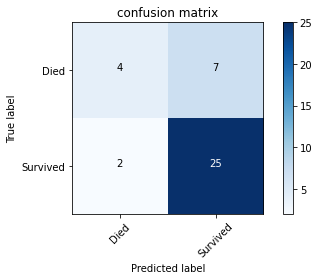

In [ ]:
cm=confusion_matrix(y_test,pred_test)
plot_confusion_matrix(cm=cm,classes=["Died","Survived"])
print(classification_report(y_test,pred_test))